In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46425")
client

<Client: 'tcp://127.0.0.1:46425' processes=8 threads=40, memory=157.36 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
import gsw
import time
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/spectre/tuchida/chaocean/Snap/'
tdgs = '/tank/tdgs/tuchida/TWA/'
topog = '/tank/topog/tuchida/TWA/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,dd:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [58]:
dsg = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                              % (100)), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=ntimes[0,0], 
                     ).isel(time=0).chunk({'YC':ychunk,'YG':ychunk,
                                           'XC':xchunk,'XG':xchunk})

dsg

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46)
Coordinates: (12/33)
    iter     int64 1421280
    time     timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
Data variables:
    THETA    (Z, YC, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    SALT     (Z, YC, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    UVEL     (Z, YC, XG) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    VVEL     (Z, YG, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    WVEL     (Zl, YC, XC) >f4 dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [6]:
xchunk = 100
ychunk = 100
dCs = 1e-5
# iiter = 1419120
# Cs = xr.open_dataset(op.join(savedir,"Max-sound-speed_%010d.nc" % iiter)).Cs
Cs = xr.open_dataset(op.join(savedir,"Max-snap-sound-speed_1967.nc")).Cs
Cs

<xarray.DataArray 'Cs' (Z: 46)>
[46 values with dtype=float32]
Coordinates:
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 ...
    PHrefC   (Z) float32 ...
    rhoRef   (Z) float32 ...
    iter     int64 ...
    time     timedelta64[ns] ...

In [42]:
Dsig = 30
sigmin = 20.7
nlayers = 55
# siglayers = np.linspace(19,48,nlayers)
xs, xe = (0,3)
tanh1 = np.tanh(np.arange(xs, xe, (xe-xs)/nlayers))
amp = (tanh1.max()-tanh1.min())
siglayers = (tanh1-tanh1.min())*amp**-1*Dsig + sigmin
tanh2 = np.tanh(np.arange(xs-(xe-xs)/(2*nlayers), xe+(xe-xs)/(2*nlayers), (xe-xs)/nlayers))
sigp1layers = (tanh2-tanh1.min())*amp**-1*Dsig + sigmin
sigp1layers

array([19.87748589, 21.52251411, 23.16266133, 24.78828089, 26.3900663 ,
       27.9592593 , 29.48783169, 30.96863315, 32.39550054, 33.76332625,
       35.06808655, 36.30683264, 37.47764918, 38.57958635, 39.61257177,
       40.57730893, 41.47516829, 42.30807618, 43.07840633, 43.7888772 ,
       44.44245763, 45.04228256, 45.59157937, 46.09360526, 46.55159508,
       46.96871932, 47.34805099, 47.69254071, 48.0049987 , 48.28808288,
       48.54429183, 48.77596193, 48.98526774, 49.17422489, 49.34469495,
       49.4983917 , 49.63688843, 49.76162575, 49.87391989, 49.97497099,
       50.06587145, 50.14761397, 50.22109942, 50.28714429, 50.34648776,
       50.39979833, 50.44768006, 50.49067835, 50.52928522, 50.56394433,
       50.59505545, 50.62297864, 50.64803802, 50.67052527, 50.69070274,
       50.70880637, 50.72504823])

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. 

<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 900, delta_outer: 56, delta: 55)
Coordinates:
  * XC           (XC) >f4 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC           (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * delta_outer  (delta_outer) float64 20.7 22.34 23.98 ... 50.68 50.7 50.72
  * delta        (delta) float64 21.52 23.16 24.78 26.38 ... 50.67 50.69 50.71
Data variables:
    zdz          (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 56), meta=np.ndarray>
    dzetaF       (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 56), meta=np.ndarray>


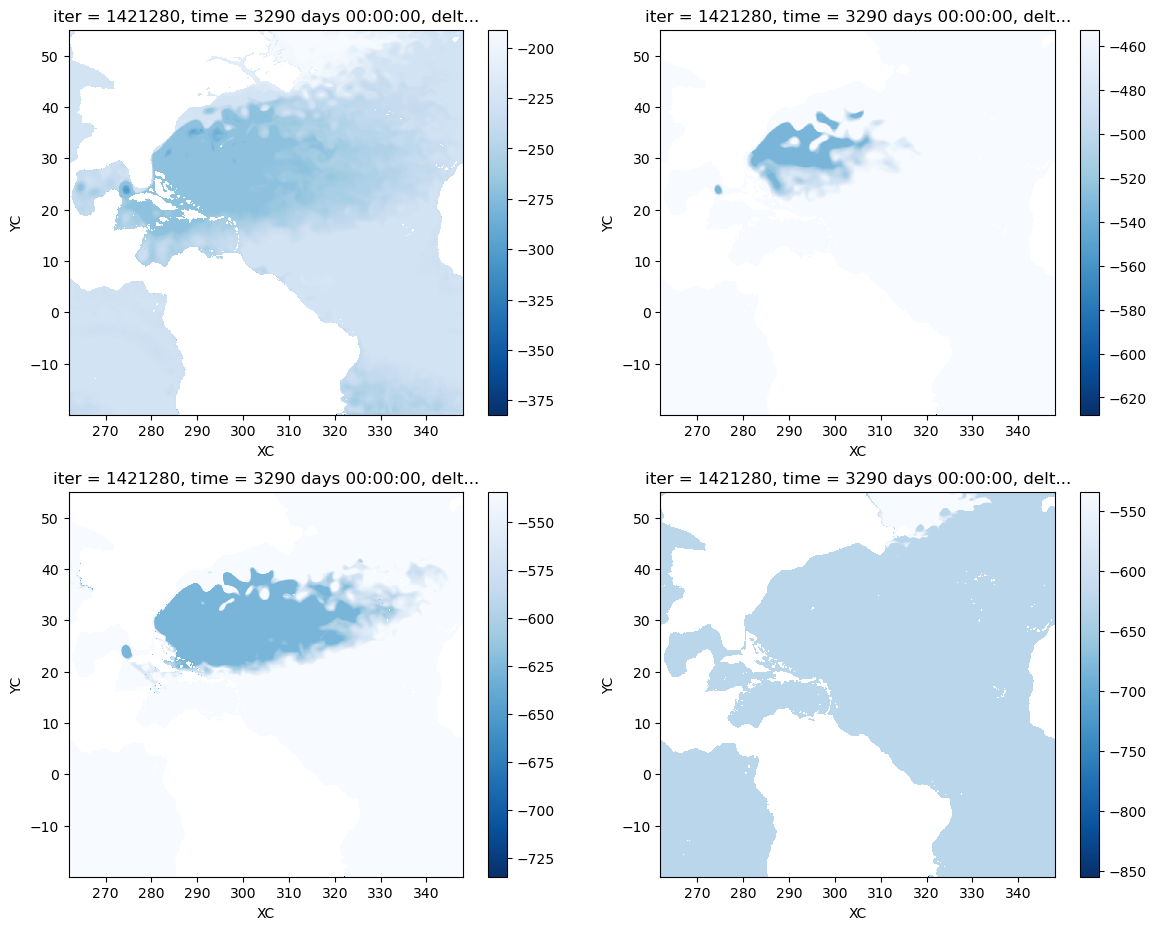

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. 

1421280


In [43]:
ystart = ySstart
yy = yystart
nmembs = range(100,148)

for year in years[yystart:]:
    if year == years[yystart]:
        mtimes = ntimes[yy,:1]
    else:
        mtimes = ntimes[yy]
        
    for itime in mtimes:
            
        for imemb in nmembs:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (imemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=itime, 
                                ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                      'YC':ychunk,'YG':ychunk})
            
            theta = ds.THETA.where(ds.maskC!=0.)
            salt = ds.SALT.where(ds.maskC!=0.)

            xA = ds.hFacW * ds.dyG * ds.drF
            yA = ds.hFacS * ds.dxG * ds.drF
            dxC_r = ds.dxC**-1
            dyC_r = ds.dyC**-1
            dxG_r = ds.dxG**-1
            dyG_r = ds.dyG**-1
            drF_r = ds.drF**-1
            drC_r = ds.drC**-1
            hFacC_r = ds.hFacC**-1
            rA_r = ds.rA**-1
            pres = grav*np.abs(ds.Z)
            presp1 = grav*np.abs(ds.Zp1)
            grid = Grid(ds, periodic=['X'])

            rho_til = rhoConst*(1. - grav*(-grid.cumsum((Cs+dCs)**-2*ds.drF, 'Z',
                                                        boundary='extend', to='outer')
                                          )
                               ).chunk({'Zp1':-1})
            if itime == mtimes[0] and imemb == 0:
                print(rho_til)

############################################
#                   Rhos                   #
############################################
            rho_outer = xr.apply_ufunc(densjmd95, 
                                       grid.interp(salt,'Z',boundary='extend',to='outer'), 
                                       grid.interp(theta,'Z',boundary='extend',to='outer'), 
                                       presp1, 
                                       dask='parallelized', output_dtypes=[float,]
                                      ).chunk({'XC':xchunk,'YC':ychunk})

            delta_outer = (rho_outer - rho_til).chunk({'Zp1':-1}).rename('delta_outer')
            # if imemb == 100:
            #     delta_outer.name='delta'
            #     xhist(delta_outer,bins=np.linspace(20,100,30)).plot()
            #     plt.show()
#             if year == years[yystart] and itime == mtimes[0] and imemb == 0:
#                 print(delta_outer)
#                 fig, axes = plt.subplots(figsize=(14,11), nrows=2, ncols=2)
# #                 fig.set_tight_layout(True)
#                 delta_outer.isel(time=0,Zp1=0).plot(ax=axes[0,0])
#                 delta_outer.isel(time=0,Zp1=1).plot(ax=axes[0,1])
#                 delta_outer.isel(time=0,Zp1=20).plot(ax=axes[1,0])
#                 delta_outer.isel(time=0,Zp1=40).plot(ax=axes[1,1])

##############################################
#                     Zs                     #
##############################################
#         start = time.time()
            zz = (xr.ones_like(ds.THETA) * ds.Z
                 ).where(ds.maskC!=0.).chunk({'YC':ychunk,'XC':xchunk})
            zetadz = grid.transform(zz.fillna(0.)*ds.drF,
                                    'Z',
                                    sigp1layers,
                                    method='conservative',
                                    target_data=delta_outer)
            
            dzz = (xr.ones_like(ds.THETA) * ds.drF
                  ).where(ds.maskC!=0.).chunk({'YC':ychunk,'XC':xchunk})
            
            dzetaF = grid.transform(dzz.fillna(0.),
                                    'Z',
                                    sigp1layers,
                                    method='conservative',
                                    target_data=delta_outer)
##############################################
            dsave = zetadz.to_dataset(name='zdz')
            dsave['dzetaF'] = dzetaF.where(dzetaF!=0.)
            delta = .5*(dsave.delta_outer[1:].data 
                        + dsave.delta_outer[:-1].data)
            dsave = dsave.reset_coords(drop=True)
            dsave.coords['delta'] = ('delta',delta)
            if year == years[yystart] and itime == mtimes[0] and imemb == 100:
                print(dsave)
                fig, axes = plt.subplots(figsize=(14,11), nrows=2, ncols=2)
                (zetadz/dzetaF).where(dzetaF!=0.).isel(delta_outer=10).plot(ax=axes[0,0], 
                                                                            cmap='Blues_r')
                (zetadz/dzetaF).where(dzetaF!=0.).isel(delta_outer=20).plot(ax=axes[0,1], 
                                                                            cmap='Blues_r')
                (zetadz/dzetaF).where(dzetaF!=0.).isel(delta_outer=30).plot(ax=axes[1,0], 
                                                                            cmap='Blues_r')
                (zetadz/dzetaF).where(dzetaF!=0.).isel(delta_outer=40).plot(ax=axes[1,1], 
                                                                            cmap='Blues_r')
                plt.show()
            dsave.to_zarr(op.join(savedir,'run%4d/Zs/memb%02d/%010d/' 
                                  % (year,imemb,itime)), mode='w')
            dsave.close()
            del zz, zetadz
            del dzetaF, dzz
    #         print("Zs saved.")

            ds.close()

        print(itime)
        
    yy += 1

In [27]:
print(delta_outer.min().values, delta_outer.max().values)

19.956949097298434 153.6752878526222


In [63]:
for ii in range(100,148):
    if ii == 100:
        ds = xr.open_zarr(op.join(savedir,'run%4d/Zs/memb%02d/%010d/' 
                                  % (year,ii,itime)))
    else:
        ds = xr.concat([ds, xr.open_zarr(op.join(savedir,'run%4d/Zs/memb%02d/%010d/' 
                                  % (year,ii,itime)))
                       ], 'nmemb'
                      )
ds

<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 900, delta: 55, delta_outer: 56, nmemb: 48)
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -19.92 -19.83 -19.75 -19.67 ... 54.83 54.92 55.0
  * delta        (delta) float64 21.52 23.16 24.78 26.38 ... 50.67 50.69 50.71
  * delta_outer  (delta_outer) float64 20.7 22.34 23.98 ... 50.68 50.7 50.72
Dimensions without coordinates: nmemb
Data variables:
    dzetaF       (nmemb, YC, XC, delta_outer) float32 dask.array<chunksize=(1, 100, 100, 56), meta=np.ndarray>
    zdz          (nmemb, YC, XC, delta_outer) float32 dask.array<chunksize=(1, 100, 100, 56), meta=np.ndarray>

In [64]:
zeta = (ds.zdz * ds.dzetaF**-1).where(ds.dzetaF!=0.)

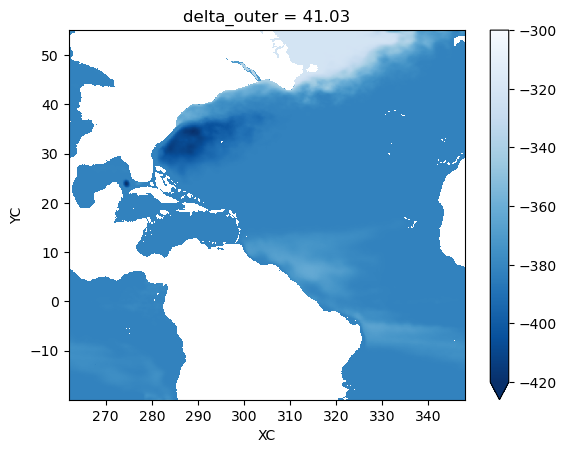

In [65]:
zeta.isel(delta_outer=15).mean('nmemb').plot(vmax=-300, vmin=-420, cmap='Blues_r')

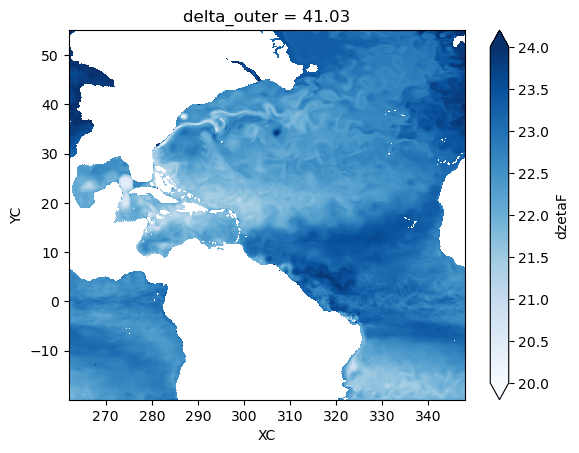

In [87]:
ds.dzetaF.isel(delta_outer=15,nmemb=10).plot(cmap='Blues', vmax=24, vmin=20)

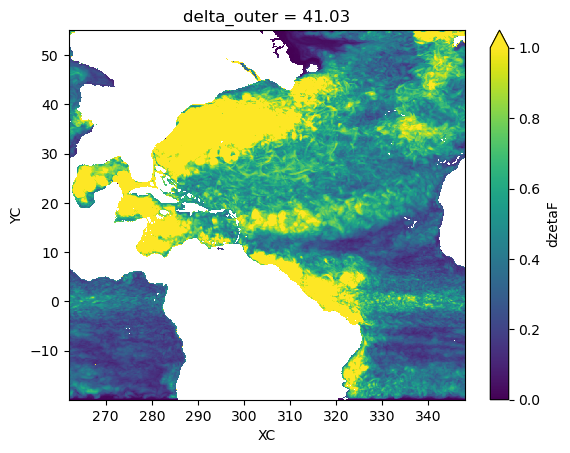

In [99]:
(ds.dzetaF.max('nmemb')-ds.dzetaF.min('nmemb')).isel(delta_outer=15).plot(vmax=1.)

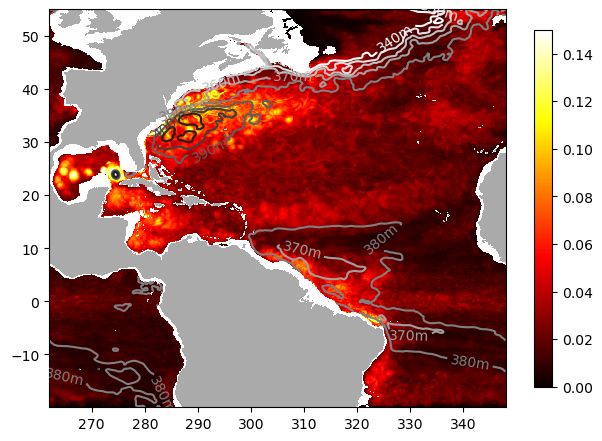

In [101]:
# This custom formatter removes trailing zeros, e.g. "1.0" becomes "1", and
# then adds a percent sign.
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}m" if plt.rcParams["text.usetex"] else f"{s}m"

fig, ax = plt.subplots()
fig.set_tight_layout(True)
im = ax.pcolormesh(ds.XC, ds.YC, 
                   ((ds.dzetaF.max('nmemb')-ds.dzetaF.min('nmemb'))
                    / ds.dzetaF.mean('nmemb')
                   ).where(ds.dzetaF.mean('nmemb')!=0.).isel(delta_outer=15),
                   vmin=0., vmax=.15, cmap='hot',
                   rasterized=True
                  )
cs = ax.contour(ds.XC, ds.YC,
                np.abs(zeta.isel(delta_outer=15).mean('nmemb')),
                levels=np.linspace(340,420,9), extend='both',
                cmap='binary'
                # colors='k'
               )
ax.pcolormesh(dsg.XC, dsg.YC,
              ds.dzetaF.where(ds.dzetaF.mean('nmemb')==0.),
              vmin=-2, vmax=1, cmap='copper', rasterized=True
             )
for c in cs.collections:
    c.set_rasterized(True)
ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=10)
ax.set_aspect('equal')
fig.colorbar(im, ax=ax, shrink=.8)